In [ ]:
import sys
sys.path.append('../')

import torch 
import torch.nn as nn 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from models.regression import Network
from compute_ntk import get_ntk, get_fnet_single
from utils import get_relative_norm
from boston.dataset import BostonDataset

In [2]:
dataset = BostonDataset(path="../boston/Boston.csv")

x_ntk = torch.stack([dataset[i][0] for i in range(100)])

In [ ]:
EPOCHS=2
ITER=2

results_dict = {
    50:[[0] for _ in range(ITER)],
    100:[[0] for _ in range(ITER)],
    500:[[0] for _ in range(ITER)],
    1000:[[0] for _ in range(ITER)],
    5000:[[0] for _ in range(ITER)],
    10000:[[0] for _ in range(ITER)],
}

In [17]:
for dim in results_dict.keys():
    for iter in range(ITER):
        print(f'*** Working on model {dim} , iter {iter+1}/{ITER} ***')

        model = Network(dim)
        parameters = {k:v.detach() for k, v in model.named_parameters()}

        fnet_single = get_fnet_single(model)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        ntk_init = get_ntk(fnet_single, parameters, x_ntk, multi=False)

        pbar = trange(EPOCHS)
        for epoch in pbar:
            epoch_loss = 0
            for x, y in dataset:
                pred = model(x)
                loss = criterion(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss+=loss.item()

            pbar.set_description(f"for epoch {epoch/1}/{EPOCHS} ; training loss : {epoch_loss}")

            parameters = {k:v.detach() for k, v in model.named_parameters()}
            ntk = get_ntk(fnet_single, parameters, x_ntk)
            rel_norm = get_relative_norm(ntk, ntk_init)
            results_dict[dim][iter].append(rel_norm)

*** Working on model 50 , iter 1/2 ***


for epoch 1.0/2 ; training loss : 298768.91122055054: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


*** Working on model 50 , iter 2/2 ***


for epoch 1.0/2 ; training loss : 301853.083278656: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]  


*** Working on model 100 , iter 1/2 ***


for epoch 1.0/2 ; training loss : 299326.76535987854: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


*** Working on model 100 , iter 2/2 ***


for epoch 1.0/2 ; training loss : 296935.37069892883: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


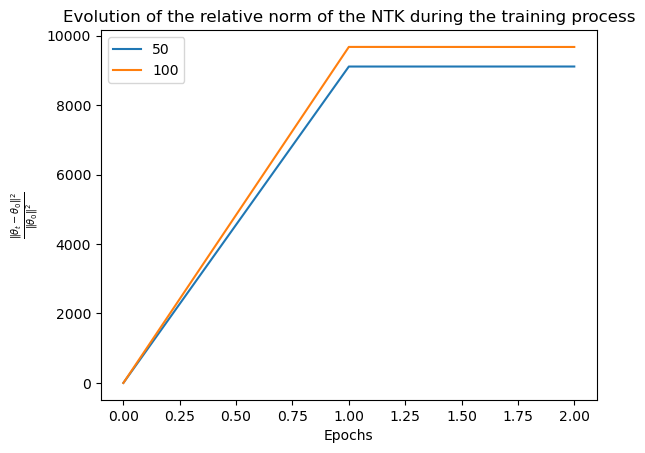

In [18]:
for dim in results_dict.keys():
    mean_results=np.mean(results_dict[dim], axis=0)
    plt.plot(mean_results, label=dim)

plt.xlabel('Epochs')
plt.ylabel(r'$\frac{\|\theta_t - \theta_0\|^2}{\|\theta_0\|^2}$')
plt.title("Evolution of the relative norm of the NTK during the training process")
plt.legend()
